# 모델 에러 분석 (Error Analysis)

이 노트북에서는 학습된 최적 모델(Tuned Model)의 예측 결과를 분석합니다.
Test Set에서의 오분류(False Positive, False Negative) 사례를 상세히 뜯어보고,
모델이 왜 틀렸는지(SHAP), 어떤 패턴의 판매자를 놓치고 있는지 파악하여 개선 아이디어를 도출합니다.

In [ ]:
import glob
import os

import joblib
import pandas as pd
import plotly.express as px
import shap
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from src.features.feature_generation import FeatureGenerator

# 시각화 설정
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## 1. 데이터 로드 및 전처리
학습 때와 동일한 방식으로 피처 엔지니어링을 수행합니다.

In [13]:
# 1. 데이터 로드 및 피처 생성
generator = FeatureGenerator().load_data(from_db=True)
features_df = generator.generate_legacy_features()

# 타겟 및 피처 정의 (동일한 컬럼 순서 유지)
feature_columns = [
    'satisfaction_score', 'review_count', 'total_product_count',
    'product_count_actual', 'price_mean', 'price_std', 'price_min', 'price_max',
    'rating_mean', 'rating_std', 'review_sum', 'review_mean',
    'discount_mean', 'discount_max', 'shipping_fee_mean', 'shipping_days_mean',
    'review_count_actual', 'review_rating_mean', 'review_rating_std',
    'review_length_mean', 'review_length_std', 'review_length_max',
    'question_count', 'answer_rate'
]

X = features_df[feature_columns]
y = features_df['is_abusing_seller'].astype(int)

print(f"데이터 준비 완료: {features_df.shape}")

데이터 준비 완료: (401, 26)


## 2. 모델 및 스케일러 로드

In [14]:
# 저장된 모델 찾기
model_files = glob.glob('../models/abusing_detector_tuned_*.pkl')
if not model_files:
    raise FileNotFoundError("모델 파일을 찾을 수 없습니다. 05_model_improvement.ipynb를 먼저 실행해주세요.")

# 가장 최근 파일 사용
latest_model_path = max(model_files, key=os.path.getctime)
print(f"로드할 모델: {latest_model_path}")

model = joblib.load(latest_model_path)
scaler = joblib.load('../models/scaler_tuned.pkl')
print("모델 및 스케일러 로드 완료")

로드할 모델: ../models/abusing_detector_tuned_tuned_rf.pkl
모델 및 스케일러 로드 완료


## 3. Test Set 예측 및 평가
학습 때와 동일한 random_state(42)로 분리하여 Test Set을 확보합니다.

In [15]:
# Train/Test 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 모델 타입 확인 후 스케일링 여부 결정
# RF, GB 같은 트리 기반 모델은 스케일링 불필요
model_type = str(type(model).__name__)
print(f"모델 타입: {model_type}")

if 'RandomForest' in model_type or 'GradientBoosting' in model_type or 'XGB' in model_type:
    print("→ 트리 기반 모델: 스케일링 없이 원본 데이터 사용")
    X_test_eval = X_test
else:
    print("→ 스케일링 필요 모델: 스케일링 적용")
    X_test_eval = scaler.transform(X_test)

# 예측
y_pred = model.predict(X_test_eval)
y_proba = model.predict_proba(X_test_eval)[:, 1]

# 평가 결과
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

모델 타입: RandomForestClassifier
→ 트리 기반 모델: 스케일링 없이 원본 데이터 사용

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94        43
           1       0.95      0.92      0.93        38

    accuracy                           0.94        81
   macro avg       0.94      0.94      0.94        81
weighted avg       0.94      0.94      0.94        81



## 4. 오분류(Error) 분석

Confusion Matrix를 통해 오분류 유형을 파악합니다.
- **FP (False Positive)**: 정상 판매자를 어뷰징으로 오인 (억울한 판매자 발생)
- **FN (False Negative)**: 어뷰징 판매자를 정상으로 오인 (탐지 실패)

In [16]:
# Confusion Matrix 시각화
cm = confusion_matrix(y_test, y_pred)
labels = ['Normal (0)', 'Abusing (1)']

fig = px.imshow(cm, text_auto=True, 
                x=labels, y=labels,
                labels=dict(x="Predicted Label", y="True Label"),
                color_continuous_scale="Blues")
fig.update_layout(title="Confusion Matrix", width=600, height=500)
fig.show()

In [17]:
# 분석용 데이터프레임 생성
analysis_df = X_test.copy()
analysis_df['company_name'] = features_df.loc[X_test.index, 'company_name']
analysis_df['actual'] = y_test
analysis_df['predicted'] = y_pred
analysis_df['prob_abusing'] = y_proba

# 에러 유형 정의
analysis_df['error_type'] = 'Correct'
analysis_df.loc[(analysis_df['actual'] == 0) & (analysis_df['predicted'] == 1), 'error_type'] = 'False Positive' # 정상인데 어뷰징이라 예측
analysis_df.loc[(analysis_df['actual'] == 1) & (analysis_df['predicted'] == 0), 'error_type'] = 'False Negative' # 어뷰징인데 정상이라 예측

print("에러 유형 분포:")
print(analysis_df['error_type'].value_counts())

에러 유형 분포:
error_type
Correct           76
False Negative     3
False Positive     2
Name: count, dtype: int64


### 4.1 False Positive 분석 (정상 -> 어뷰징 오탐)
정상적인 판매자인데 왜 어뷰징으로 의심받았을까요? 특징을 살펴봅니다.

In [18]:
fp_df = analysis_df[analysis_df['error_type'] == 'False Positive'].sort_values('prob_abusing', ascending=False)

print(f"총 {len(fp_df)}건의 False Positive 발견")
display(fp_df[['company_name', 'actual', 'predicted', 'prob_abusing', 'review_count', 'satisfaction_score', 'rating_mean', 'review_length_mean']])

총 2건의 False Positive 발견


,company_name,actual,predicted,prob_abusing,review_count,satisfaction_score,rating_mean,review_length_mean
303,제이와이스타일,0,1,0.761363,14,71,4.5,226.652174
185,디포터,0,1,0.708309,14,60,4.5,299.454545


CASE: 제이와이스타일 (Prob: 0.7614)


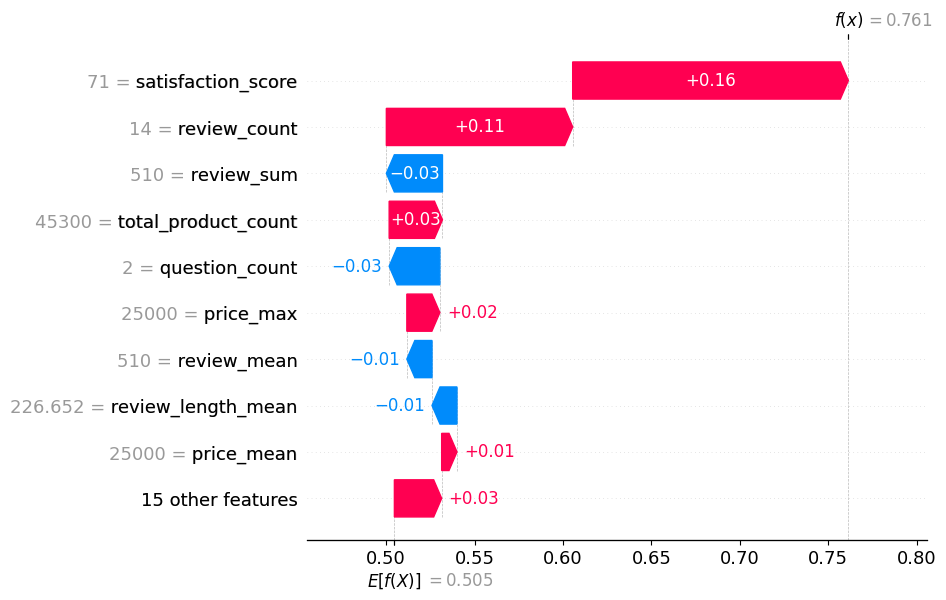

In [19]:
# FP 사례에 대한 SHAP 분석 (가장 확신을 가지고 틀린 케이스)
if len(fp_df) > 0:
    target_idx = fp_df.index[0]
    target_row_loc = list(X_test.index).index(target_idx)
    
    print(f"CASE: {fp_df.iloc[0]['company_name']} (Prob: {fp_df.iloc[0]['prob_abusing']:.4f})")
    
    # Explainer (TreeExplainer 권장, 여기선 일반화를 위해 KernelExplainer 예시일 수 있으나 joblib 로드된 모델 타입에 따라 다름)
    # 모델 타입 확인 후 Explainer 생성
    if 'RandomForest' in str(type(model)) or 'GradientBoosting' in str(type(model)) or 'XGB' in str(type(model)):
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test_eval)
        
        # Waterfall Plot & Value Exception Handling
        if isinstance(shap_values, list):
            sv = shap_values[1][target_row_loc]
        elif hasattr(shap_values, 'shape') and len(shap_values.shape) == 3:
            sv = shap_values[target_row_loc, :, 1]
        else:
            sv = shap_values[target_row_loc]

        # Base Value Handling
        if isinstance(explainer.expected_value, list):
            bv = explainer.expected_value[1]
        elif hasattr(explainer.expected_value, '__iter__') and len(explainer.expected_value) > 1:
            bv = explainer.expected_value[1]
        else:
            bv = explainer.expected_value
            
        explanation = shap.Explanation(values=sv, base_values=bv, data=X_test.iloc[target_row_loc].values, feature_names=feature_columns)
        shap.plots.waterfall(explanation)
    else:
        print("트리 기반 모델이 아니어서 SHAP TreeExplainer를 건너뜁니다.")

### 4.2 False Negative 분석 (어뷰징 -> 정상 미탐)
어뷰징 판매자임에도 불구하고 왜 정상으로 판단했을까요? (가장 위험한 케이스)

In [20]:
fn_df = analysis_df[analysis_df['error_type'] == 'False Negative'].sort_values('prob_abusing')

print(f"총 {len(fn_df)}건의 False Negative 발견")
display(fn_df[['company_name', 'actual', 'predicted', 'prob_abusing', 'review_count', 'satisfaction_score', 'rating_mean', 'review_length_mean']])

총 3건의 False Negative 발견


,company_name,actual,predicted,prob_abusing,review_count,satisfaction_score,rating_mean,review_length_mean
328,진코,1,0,0.231067,93,92,5.0,376.40
291,잎새얀새,1,0,0.396064,96,96,5.0,617.05
149,BOT,1,0,0.400687,588,87,5.0,481.20


CASE: 진코 (Prob: 0.2311)


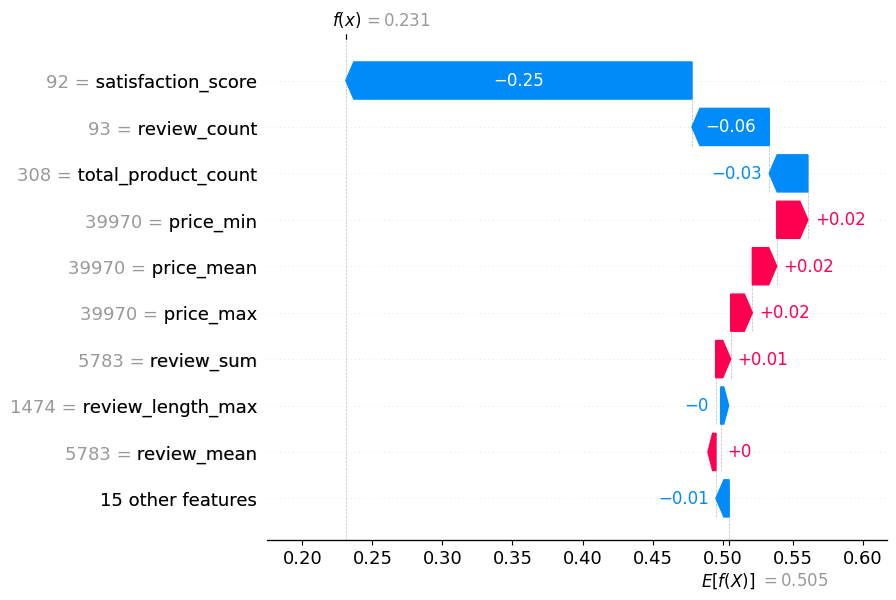

In [21]:
# FN 사례에 대한 SHAP 분석
if len(fn_df) > 0:
    target_idx = fn_df.index[0]
    target_row_loc = list(X_test.index).index(target_idx)
    
    print(f"CASE: {fn_df.iloc[0]['company_name']} (Prob: {fn_df.iloc[0]['prob_abusing']:.4f})")
    
    if 'RandomForest' in str(type(model)) or 'GradientBoosting' in str(type(model)):
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test_eval)
        # Waterfall Plot & Value Exception Handling
        if isinstance(shap_values, list):
            sv = shap_values[1][target_row_loc]
        elif hasattr(shap_values, 'shape') and len(shap_values.shape) == 3:
            sv = shap_values[target_row_loc, :, 1]
        else:
            sv = shap_values[target_row_loc]

        # Base Value Handling
        if isinstance(explainer.expected_value, list):
            bv = explainer.expected_value[1]
        elif hasattr(explainer.expected_value, '__iter__') and len(explainer.expected_value) > 1:
            bv = explainer.expected_value[1]
        else:
            bv = explainer.expected_value
        
        explanation = shap.Explanation(values=sv, base_values=bv, data=X_test.iloc[target_row_loc].values, feature_names=feature_columns)
        shap.plots.waterfall(explanation)
    else:
        print("트리 기반 모델이 아니어서 SHAP TreeExplainer를 건너뜁니다.")

## 5. 에러 유형별 피처 분포 비교
정상(TN), 어뷰징(TP) 그리고 에러(FP, FN) 그룹 간에 피처 분포 차이를 확인합니다.
어떤 피처가 모델을 헷갈리게 만들었는지 직관적으로 볼 수 있습니다.

In [22]:
# 주요 피처 선정 (SHAP 중요도 기반으로 선정하는 것이 좋으나, 여기선 임의 지정)
key_features = ['satisfaction_score', 'review_count', 'price_mean', 'review_length_mean', 'answer_rate']

for col in key_features:
    fig = px.box(analysis_df, x='error_type', y=col, color='error_type', 
                 title=f'{col} Distribution by Error Type',
                 points="all")
    fig.show()